In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

import sys
sys.path.insert(0, '../')

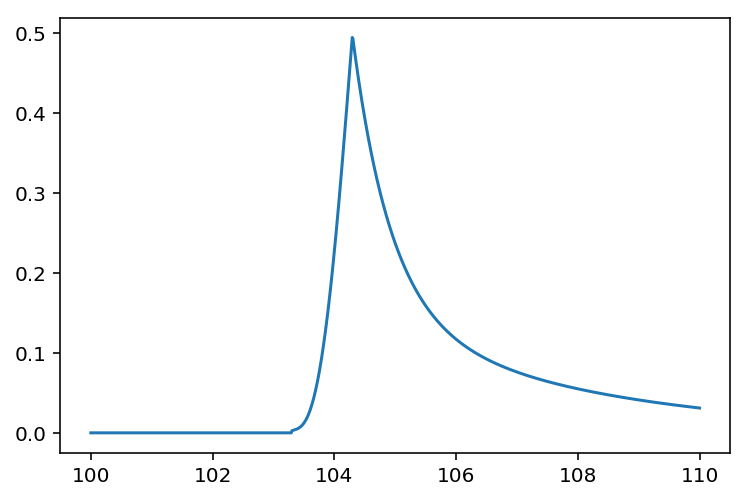

In [4]:
from libra import flare_flux

times = np.linspace(100, 110, 1000)

time_at_peak_flux = 104.3
maximum_flux = 0.5
duration_fwhm = 1

fluxes = flare_flux(times, time_at_peak_flux, maximum_flux, duration_fwhm)

plt.plot(times, fluxes)

## What about wavelength dependence? 

Suzanne says you can assume the flare has the spectrum of an A star momentarily, with $T_\mathrm{eff} \sim 10000$ K.

Assuming we're in the Rayleigh-Jean's limit for the A star, let's assume it's a blackbody. 

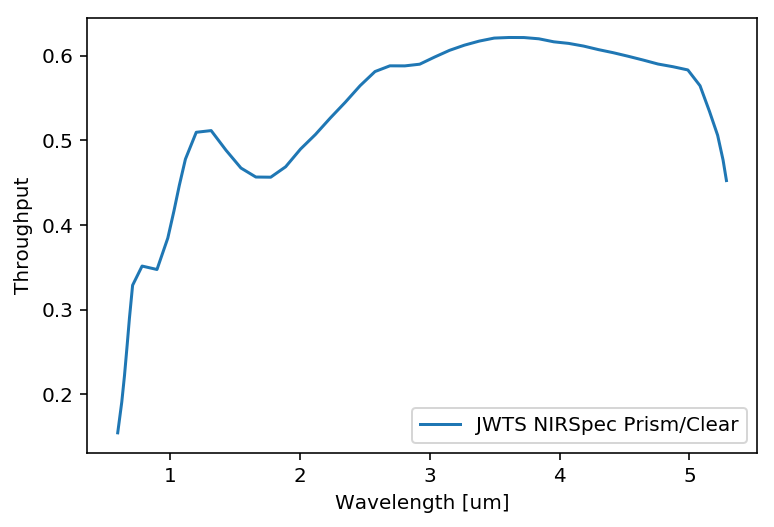

In [6]:
jwst_wl, jwst_throughput = np.loadtxt('../libra/data/etc/NIRSpec_S1600_prism_clear_throughput.csv', 
                                      delimiter=',', unpack=True)
jwst_wl *= u.um

plt.plot(jwst_wl, jwst_throughput, label='JWTS NIRSpec Prism/Clear')

plt.legend()
plt.gca().set(xlabel='Wavelength [um]', ylabel='Throughput');

erg / (Angstrom cm2 s sr)


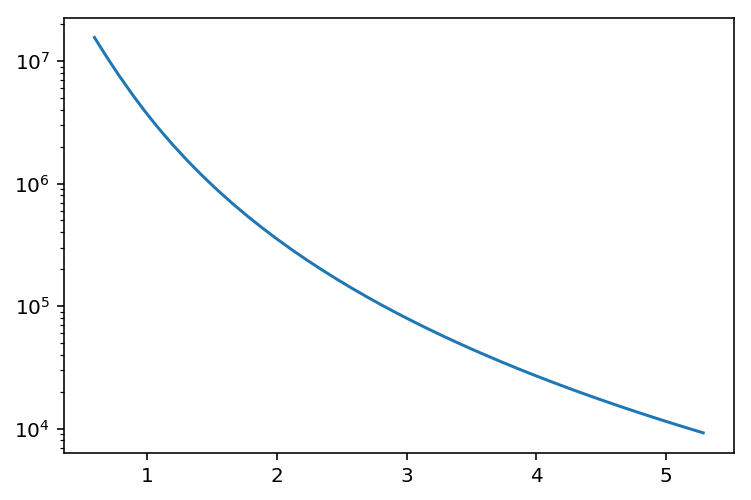

In [13]:
from astropy.modeling.blackbody import blackbody_lambda


bb = blackbody_lambda(jwst_wl, 10000*u.K)
print(bb.unit)
plt.semilogy(jwst_wl, bb)

## <a href="#ffd">Observed TRAPPIST-1 flare frequency</a>

In [18]:
_, log_e, log_ed, log_nu = np.loadtxt('../libra/data/trappist1_ffd_davenport.csv', 
                                      unpack=True, delimiter=',', skiprows=1)

[Text(0,0.5,'freqency [1/day]'), Text(0.5,0,'Log Energy (erg)')]

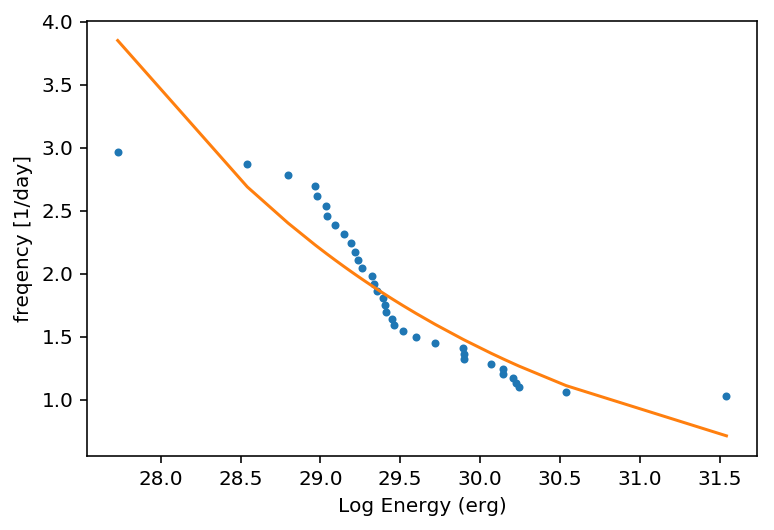

In [150]:
fig, ax = plt.subplots()
ax.plot(log_e, 10**log_nu, '.')

p = np.polyfit(log_e, log_nu, 1)

p_inv = np.polyfit(log_nu, log_e, 1)

log_nu_fit = np.polyval(p, log_e)

ax.plot(log_e, 10**log_nu_fit)

ax.set(xlabel='Log Energy (erg)', ylabel='freqency [1/day]')

In [154]:
p

array([-0.19222414,  5.91595501])

Text(0,0.5,'(Counts [d$^{-1}$]) $\\times$ (obs. duration [d])')

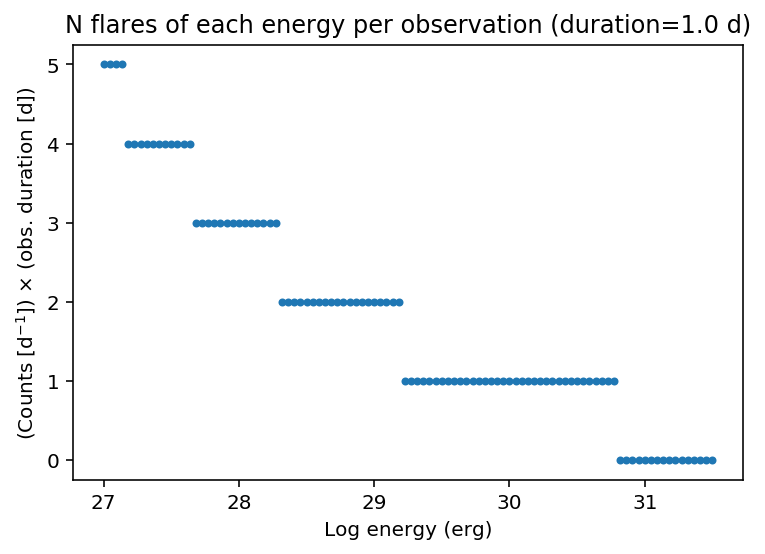

In [135]:
energy_range = np.linspace(27, 31.5, 100)

log_nu_fit = np.polyval(p, energy_range)

observation_duration = 1 * u.d #1*u.s #

counts_decimal = observation_duration * (10**log_nu_fit / u.d)
counts = np.floor(counts_decimal)

plt.title("N flares of each energy per observation (duration={0})".format(observation_duration))
plt.plot(energy_range, counts, '.')
plt.xlabel('Log energy (erg)')
plt.ylabel(r'(Counts [d$^{-1}$]) $\times$ (obs. duration [d])')

In [136]:
observed_flare_energies = []

for integer in np.unique(counts): 
    # Minimum energy flare
    min_energy = np.min(energy_range[counts == integer])
    # Maximum energy flare
    max_energy = np.max(energy_range[counts == integer])
    # Randomly draw an integer number of flares from this energy range
    sample_energy = ((max_energy - min_energy)*np.random.rand(int(integer)) + min_energy)
    print("min={0:.2f}, max={1:.2f}, samples={2}".format(min_energy, max_energy, sample_energy))
    
    observed_flare_energies.extend(sample_energy)

min=30.82, max=31.50, samples=[]
min=29.23, max=30.77, samples=[ 29.46285969]
min=28.32, max=29.18, samples=[ 28.39313988  29.15078535]
min=27.68, max=28.27, samples=[ 28.19783892  27.90283278  27.74390652]
min=27.18, max=27.64, samples=[ 27.29824065  27.46680619  27.55602061  27.30357069]
min=27.00, max=27.14, samples=[ 27.05690602  27.12745682  27.10174795  27.03060031  27.09555445]


In [155]:
def get_flares(observation_duration, verbose=False, 
               min_flare_energy=28, max_flare_energy=31.5):
    """
    For an observation of length ``observation_duration``, 
    return energies of all flares that will occur, assuming we 
    truncate the flare distribution on 
    ``(min_flare_energy, max_flare_energy)``. 
    """
    energy_range = np.linspace(min_flare_energy, max_flare_energy, 100)

    best_fit_params = np.array([-0.19222414,  5.91595501])
    log_nu_fit = np.polyval(best_fit_params, energy_range)
    
    counts_decimal = observation_duration * (10**log_nu_fit / u.day)
    counts = np.floor(counts_decimal)

    observed_flare_energies = []

    for integer in np.unique(counts): 
        # Minimum energy flare
        min_energy = np.min(energy_range[counts == integer])
        # Maximum energy flare
        max_energy = np.max(energy_range[counts == integer])
        # Randomly draw an integer number of flares from this energy range
        sample_energy = ((max_energy - min_energy)*np.random.rand(int(integer)) + min_energy)
        if verbose:
            print("min={0:.2f}, max={1:.2f}, samples={2}".format(min_energy, max_energy, sample_energy))

        observed_flare_energies.extend(sample_energy)
        
    return observed_flare_energies

In [162]:
# Observe flares over 1 day: 
observation_duration = 3 * u.day
observed_flares = get_flares(observation_duration)

Text(0,0.5,'# flares observed in 3.0 d')

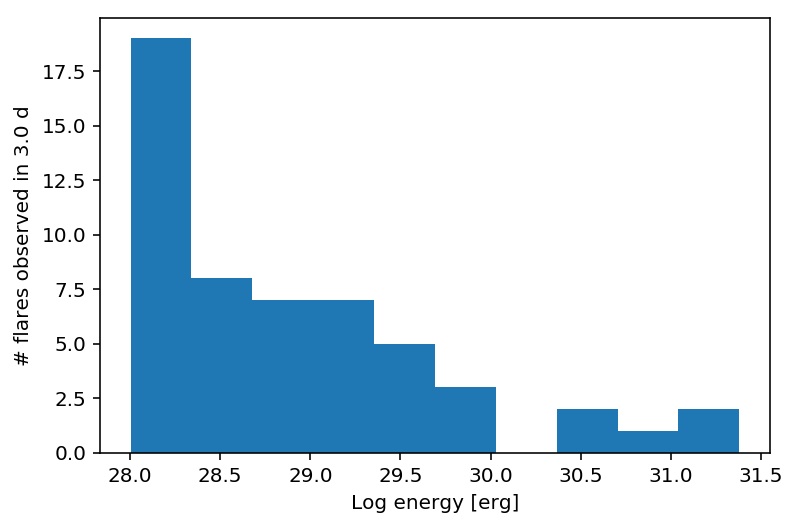

In [163]:
plt.hist(observed_flares)
plt.xlabel('Log energy [erg]')
plt.ylabel('# flares observed in {0}'.format(observation_duration))